In [1]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import scipy.io
import torch.nn as nn
import torch
import numpy as np
from sklearn.model_selection import GroupKFold,LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
from sklearn.base import TransformerMixin,BaseEstimator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from glob import glob
import scipy.io
import torch.nn as nn
import torch
import numpy as np

data_array = np.load('/content/drive/MyDrive/Colab Notebooks/data_array.npy')
label_array = np.load('/content/drive/MyDrive/Colab Notebooks/label_array.npy')
group_array = np.load('/content/drive/MyDrive/Colab Notebooks/group_array.npy')

print(data_array.shape,label_array.shape,group_array.shape)

(7150, 1250, 33) (7150,) (7150,)


In [4]:
gkf=GroupKFold()
class StandardScaler3D(BaseEstimator,TransformerMixin):
    #batch, sequence, channels
    def __init__(self):
        self.scaler = StandardScaler()

    def fit(self,X,y=None):
        self.scaler.fit(X.reshape(-1, X.shape[2]))
        return self

    def transform(self,X):
        return self.scaler.transform(X.reshape( -1,X.shape[2])).reshape(X.shape)


def three_splits(data_array , label_array, group_array):

  # Split data_array into train and validate
  train_groups = []
  for train_index, test_index in gkf.split(data_array, label_array, groups=group_array):
      train_features, train_label = data_array[train_index],label_array[train_index]
      X_test, y_test =data_array[test_index],label_array[test_index]
      train_groups = group_array[train_index]

      scaler=StandardScaler3D()
      train_features=scaler.fit_transform(train_features)
      X_test=scaler.transform(X_test)

      print(f"group={np.unique(group_array[train_index])}")
      print(f"group={np.unique(group_array[test_index])}")
      break

  # Split train_features into train and val
  for train_index, val_index in gkf.split(train_features, train_label, groups= train_groups):
      X_train, y_train =train_features[train_index],train_label[train_index]
      X_val, y_val =train_features[val_index],train_label[val_index]

      print(f"group={np.unique(group_array[train_index])}")
      print(f"group={np.unique(group_array[val_index])}")

      break

  return X_train, X_val, X_test, y_train, y_val, y_test




def two_splits(data_array , label_array, group_array):

  # Split data_array into train and validate
  train_groups = []
  for train_index, test_index in gkf.split(data_array, label_array, groups=group_array):
      X_train, y_train = data_array[train_index],label_array[train_index]
      X_test, y_test =data_array[test_index],label_array[test_index]
      train_groups = group_array[train_index]

      scaler=StandardScaler3D()
      X_train=scaler.fit_transform(X_train)
      X_test=scaler.transform(X_test)

      print(f"group={np.unique(group_array[train_index])}")
      print(f"group={np.unique(group_array[test_index])}")
      break

  return X_train, X_test, y_train, y_test


# X_train, X_val, X_test, y_train, y_val, y_test = three_splits(data_array , label_array, group_array)

X_train, X_test, y_train, y_test = two_splits(data_array , label_array, group_array)

# convert the problem from multiclass classification to binary classification
# make haemorrhage and schaemia classes as one

y_train[y_train==0] = 1
y_train[y_train==2] = 0

# y_val[y_val==0] = 1
# y_val[y_val==2] = 0

y_test[y_test==0] = 1
y_test[y_test==2] = 0

group=[ 0  1  2  3  4  5  6  7  8 10 11 12 13 15 16 18 19 20 22 23 25 27 28 29
 30 31 34 36 37 38 39 40 41 42 43 44 45 46 47]
group=[ 9 14 17 21 24 26 32 33 35]


In [5]:
# Flatten the data array for ML models
X_train = X_train.reshape(X_train.shape[0], -1)
# X_val = X_val.reshape(X_val.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
y_train = y_train.reshape(y_train.shape[0], -1)
# y_val = y_val.reshape(y_val.shape[0], -1)
y_test = y_test.reshape(y_test.shape[0], -1)


**RF with default values**

In [6]:
def fit_and_evaluate(X_train, y_train, X_test, y_test,model):

  model.fit(X_train, y_train)

  # Predictions on the test set
  y_pred = model.predict(X_test)

  # Calculate evaluation metrics
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred, average='weighted')
  recall = recall_score(y_test, y_pred, average='weighted')
  f1 = f1_score(y_test, y_pred, average='weighted')


  # Print the results
  print("Accuracy:", accuracy)
  print("Recall:", recall)
  print("Precision:", precision)
  print("F1-score:", f1)


  print("Classification Report (Test):\n", classification_report(y_test, y_pred))

  # Compute the confusion matrix for the test set
  cm_test = confusion_matrix(y_test, y_pred)

  # Plot the confusion matrix for the test set
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", cbar=False)
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")
  plt.title(f"Confusion Matrix for Decision Tree {model.__class__}")
  plt.show()

  return model

<ipython-input-6-f4c83a58cea2>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Accuracy: 0.8669558929862617
Recall: 0.8669558929862617
Precision: 0.8780885172246653
F1-score: 0.8576453434670921
Classification Report (Test):
               precision    recall  f1-score   support

           0       0.95      0.61      0.74       435
           1       0.85      0.98      0.91       948

    accuracy                           0.87      1383
   macro avg       0.90      0.80      0.83      1383
weighted avg       0.88      0.87      0.86      1383



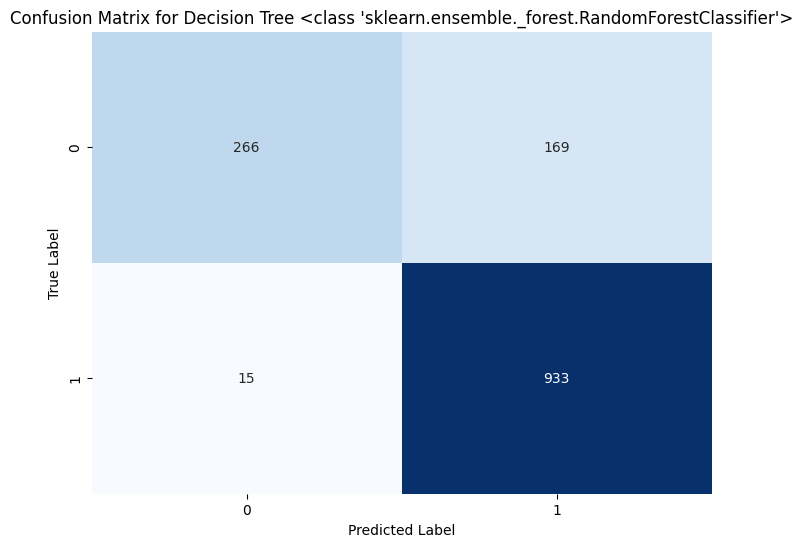

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score


model=fit_and_evaluate(X_train, y_train,X_test , y_test,RandomForestClassifier(n_estimators=25, max_features="sqrt", max_depth=9, max_leaf_nodes = 6))


In [11]:
import joblib

# Specify the full path including the filename and .joblib extension
model_path = '/content/drive/MyDrive/result/rfWithHayperParameter.joblib'

# Save your model
joblib.dump(model, model_path)

['/content/drive/MyDrive/result/rfWithHayperParameter.joblib']

**RF with GridSearch**